## Student Project

In this notebook the main results of the following paper are replicated: M. Brückner and A. Ciccone (2011) "Rain and the Democratic Window of Opportunity", *Econometrica*, Vol. 79, pp. 923-947. The paper can be found [here]( https://doi.org/10.3982/ECTA8183) $-$ data are available [here](https://www.econometricsociety.org/content/supplement-rain-and-democratic-window-opportunity-0). <br>

*Accessible in this [classroom](https://github.com/HumanCapitalAnalysis/student-project-maxschae)*.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from auxiliary import *

%matplotlib inline
sns.set()

### Story

The authors claim that temporary negative shocks to income cause political institutions in sub-Saharan Africa to become more democratic. Accordingly, negative income shocks decrease the opportunity cost of contesting political power, and to retain stability and command the ruling regime will employ more democratic institutions. Since income per capita and institutions are likely to have unobserved common causes an instrumental variable approach is taken to isolate the variation in income that is exogenous. The instrument is rainfall which is assumed to cause variation in income per capita ($\rightarrow$ IV is relevant), whereas is not correlated with institutional scores (exogeneity assumption) and its only effect on institutions is through income (exclusive restriction assumption). Rainfall affects GDP per capita by increasing agricultural production, such that droughts will have a negative impact on GDP per capita. It is ruled out that droughts lead to an economic upswing (monotonicity assumption).

The story (and this notebook) unfolds along the two stages of the estimation framework. First, to isolate the exogenous variation in income per capita, GDP per capita is related to rainfall. In the second stage, democracy score(s) are then regressed on the clean variation in income. However, first data are introduced and the identification strategy is presented.

### Data

Panel data: 41 sub-Saharan African countries between 1981 to 2004 (unbalanced) $-$ 955 observations

* Institutional scores available from the Polity IV Project (Center for Global Policy, George Mason University)

* Rainfall stems from the National Aeronautics and Space Administration (NASA) Global Precipitation Climatology Project (GPCP)

* GDP per capita data come from the Penn World Table Version 6.2 (Center for International Comparisons of Production, Income and Prices, University of Pennsylvania)

* Agricultural GDP share are reported in World Development Indicators (World Bank, online database (2009))

* Election data collected from IDEA (International Institute for Democracy and Electoral Assistance (2019))

In [2]:
df = get_panel_dataset()

#### Description of relevant variables

*Outcome Y*
* $exconst$ <br>
The executive constraint concept score ranges from -5 to 5 and larger values indicate a greater extent to which constraints are put on the decisionmaking abilities of chief executives $-$ being a single or many individuals. Institutionalized constraints can be an independent judiciary, the military if powerful, or powerful advisors. Taken from the Polity IV database.

* $exrec$ <br>
The executive recruitment concept score taken from the Polity IV database is in [-7, 7] where larger values refer to a more institutionalized and regulated procedure for transferring chief executive power.

* $polcomp$ <br>
Political competition is measured by the extent of equal opportunities for subordinates to become superordinates within and across political parties. It ranges from -9 to 9 and stems from the Polity IV database. A larger value indicates more equal chances to attain power and greater competition.

* $polity2$ <br>
The revised and combined Polity score comes from the Polity IV database, and incorporates the three preceding measures. It ranges from -10 to 10, where values between -10 and -6, -5 and 5, and 6 to 10 are called to autocracies, anocracies and democracies, respectively.

For more details the [Polity IV manual](http://www.systemicpeace.org/inscr/p4manualv2017.pdf) can be consulted. In the estimation framework changes of the outcome variable from $t-1$ to $t$ are considered. In general, variable names followed by $l$, $l2$ refer to a lag of one, two and so on. A leading $l$ indicates log variables.

*Treatment D*
* $gdp$ <br>
The treatment variable is GDP per capita. For convenience and style, income or (negative) income shocks will also be called treatment, however, GDP per capita is meant. In the estimation framework log values are used.

* $recession$ <br>
Indicator variable that equals one if GDP per capita in year is below the country's trend while controlling for shocks affecting all sub-Saharan African countries, and zero otherwise. That is, estimate $(*)$ and evaluate whether $log(GDP_{t,c})$ is below the predicted values of the model, in which $\eta_{t,c}$ constitutes the error.

\begin{align*}
log(GDP_{t, c}) = \alpha_{c}\ + \beta_{c}t\ + \phi_{t}\ + \eta_{t,c}\      (*)
\end{align*}


*Instrument Z*
* $gpcp$ <br>
The instrument is rainfall measured in millimetre of precipitation per year, where one millimeter of rainfall equals one liter of water per square meter.

* $dum$_$rain$_$20$ <br>
Indicator variable that equals one if rainfall in year is below the 20th percentile of the country-specific rainfall distribution, and zero otherwise. Droughts as defined in this notebook refer to this variable.

For the main analysis rainfall and GDP per capita as continuous variables are used for the instrument and the treatment, respectively. This has consequences for the interpretability of the treatment effects which is returned to later. Partly, drought as the instrument and recession as the treatment will be used in estimation and visualization to allow for clearer interpretation.

*Other*
* $agri gdpshare$ <br>
Stemming from the World Development Indicators (2009) the agriculture's GDP share is reported in percentage points at annual granularity.

* $election$ <br>
Indicator variable equal to 1 if parliamentary, presidential elections or both were held in that year and country.

<br>

The descriptive statistics are shown in the table below.

In [3]:
columns = ['exconst', 'exrec', 'polcomp', 'polity2', 'polity_change', 'dum_rain_20', 
           'recession_l2', 'agri_gdpshare', 'gpcp', 'lgpcp_l2', 'gdp', 'lgdp', 'election']
df[columns].describe()

,exconst,exrec,polcomp,polity2,polity_change,dum_rain_20,recession_l2,agri_gdpshare,gpcp,lgpcp_l2,gdp,lgdp,election
count,910.000000,910.000000,910.000000,955.000000,955.000000,955.000000,955.000000,893.000000,955.000000,955.000000,932.000000,932.000000,955.000000
mean,2.910989,4.802198,3.841758,-2.457592,0.249215,0.167539,0.494241,31.154650,972.681458,6.718866,1688.505737,7.072285,0.148691
std,1.767507,1.914681,3.109872,5.668427,2.097390,0.373652,0.500230,15.622894,497.613007,0.640299,1879.546631,0.756854,0.355970
min,1.000000,1.000000,1.000000,-10.000000,-15.000000,0.000000,0.000000,2.200000,96.109329,4.565486,287.024902,5.659569,0.000000
25%,1.000000,3.000000,1.000000,-7.000000,0.000000,0.000000,0.000000,19.250000,552.039703,6.332735,727.876953,6.590132,0.000000
50%,3.000000,4.000000,2.000000,-5.000000,0.000000,0.000000,0.000000,32.619999,944.346802,6.859273,915.803711,6.819801,0.000000
75%,4.000000,7.000000,7.000000,2.000000,0.000000,0.000000,1.000000,41.900002,1336.778015,7.201274,1717.437256,7.448588,0.000000
max,7.000000,8.000000,10.000000,9.000000,15.000000,1.000000,1.000000,69.330002,2587.636963,7.858500,10438.830078,9.253288,1.000000


C:\Users\Max\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Max\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


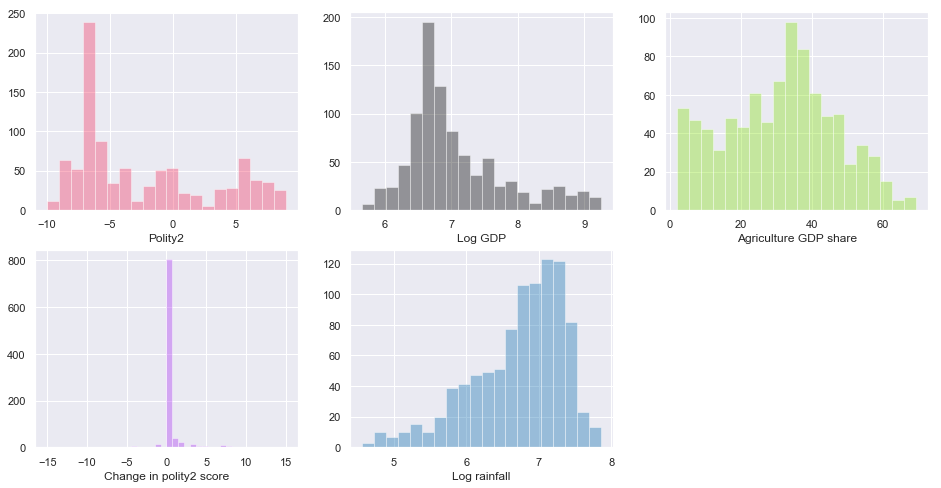

In [4]:
plot_hists()

### Identification Strategy

#### Causal graph

The basic underlying causal graph is depicted in *Graph 1*, where $Y$ denotes the outcome variable, i.e. institutional scores. $D$ refers to the treatment $-$ GDP per capita or recession indicator $-$ and $Z$ is the instrument rainfall levels or drought indicator. The node $U$ subsumes all confounding variables that are unobserved and reveals that an unblocked backdoor path from the treatment to the outcome exists, motivating the IV approach.


*Graph 1*
<img src="graphs/causal_graph_1.png" height=500 width=500 />

To cope with country-specifics and fixed effects along the time and country dimensions, the authors include time and country fixed effects as well as a country-specifc time trend. Fixed effects are used to make part of the unobservables observable $-$ i.e. unobserved characteristics that stay constant across time (country fixed effects), or analogously across countries (time fixed effects). However, it is not possible to attribute the (estimated) fixed effects to particular constant characteristics but one can only "observe" those as an aggregate. For instance, unobserved time-constant characteristics could be cultural attitude towoards innovation, risk-taking and change affecting both income and institutions. However, including fixed effects is not informative about the particular effect of cultural attitude towards risk-taking.

Consult *Graph 2* for a representation of fixed effects in the causal graph framework, and note the potentially still existing unobserved relationship between the treatment and the outcome depicted by the dashed line.


*Graph 2*
<img src="graphs/causal_graph_2.png" height=500 width=500 />

#### Threats to identification

Rainfall is a strong candidate for a natural experiment and an instrument as it cannot be influenced by countries vis-a-vis the country's population working in agriculture and by its effect on the treatment income through agricultural production. However, Rosenzweig and Wolpins offer a discussion of natural *natural experiments* where the importance of critical assessment of (wheather-based) instruments in IV designs is put forward (Rosenzweig and Wolpin (2000)). With that in mind, threats to identification for this setting are presented below.

* Violation of exogeneity assumption <br>
If the instrument has a direct causal effect on the outcome, the researcher cannot recover the causal effect of interest, i.e. *what is the effect of non-persistent income shocks on institutional scores* ($D \rightarrow Y$). In terms of the causal graph, there exists an unblocked backdoor path from the treatment to the outcome through the instrument ($D \leftarrow Z \rightarrow Y$). A direct effect is present when institutions become more democratic following the event of droughts. Such a case can occur if people connect demands of deepened democratic institutions with the call for democratic governance of water resources, for example. Then droughts would directly cause institutions to become more democratic, given protesters are granted their demands.


*Graph 3*
<img src="graphs/causal_graph_3.png" height=300 width=300 />

* Threats to exclusive restriction <br>
Identification of the causal effect of income shocks on democracy scores is not possible if the instrument has an indirect effect on democracy scores through an unobservable. The resulting backdoor path cannot be blocked and identifying the causal effect fails. Such an additional mechanism that cannot be controlled for could be present, if during droughts international organizations and donor countries scale up their aid financing but can connect this to a more constrained executive which increases the combined polity score, i.e. $Y$.


*Graph 4*
<img src="graphs/causal_graph_4.png" height=300 width=300 />

* A note on the interpretation of the causal effect <br>
The identification of the causal effect of negative transitory income shocks on improvements of institutional scores is threatened if negative rainfall shocks affect polity scores by decreasing citizens cost of contesting power not only through income but through other channels, too. The authors mention two potential channels. First, if road floodings vanish in aftermath of a drought, cost of transport and coordination of political protest would decrease. Second, Cekan (1993) finds evidence that young men are more likely to be sent to urban areas in times of drought which may decrease coordination cost of contesting power. In these cases, it is still possible to assess the impact of rainfall shocks on polity scores but the interpretation of the causal effect of interest does not withstand. That is, it cannot be argued that improvements in polity scores are due to negative income shocks.

* Monotonicty assumption not satisfied <br>
A country recovering from a severe flooding that had substantial negative effects on agricultural produce and income per capita may wittness an increase in incomes when the period of floodings is succeeded by a drought $-$ at least for an adjustment period. In this case the monotonicity assumption is violated as flipping on the instrument has different effects, i.e. a drought decreases income in one set of countries while at the same time it increases income in country A if preceded by a heavy flooding.

* Weak instrument problem <br>
Considering a more technical note, it is required that the instrument indeed causes variation in the treatment variable. A weak correlation between the instrument and the treatment only allows to use a fraction of variation in the data, which leads to an imprecise IV estimator (Morgan and Winship (2007)). Taking a closer look to the relationship between the instrument and the treatment, it becomes apparent that the implicit assumption for the instrument's relevance is that agriculture's GDP share is large and/or that a substantial amount of people work in agriculture. For countries with a neglectable agricultural sector, shocks to rainfall is a weak instrument for shocks to income. Here, effects on income due to negative effects on productivity in other sectors in times of droughts are ruled out.

The discussion on the relevance of the instrument will be revisited in the estimation section. <br>

#### Illustrating the Story

Following the introduction, the identification strategy and a short *heads-up* to potential violations of the identifying assumptions (which the reader should keep in mind in the course of this text), the following sub-section comprises visualizations of the reduced-form relationship ($Z \rightarrow Y$) and the two stages of the IV design ($Z \rightarrow D$ and $D \rightarrow Y$).

First, attention is turned to *Figure 1* replicating the paper's *Figure 1*. The graphs show the combined Polity IV score over time for nine countries $-$ due to reasons of representation minus Mali whose graph looks fairly similar to Madagascar's. The grey dashed lines indicate droughts being defined as rainfall below the 20th percentile of the country's rainfall distribution. <br>
At first sight, there are some stunning examples of countries employing much more democratic institutions in times or shortly after droughts. For instance, Kenya's institutional score increased several times shortly after droughts between 1985 and 2002. Also, Benin, Madagascar, Malawi and Mozambique witnessed substantial leaps of the Polity score in times of a negative rainfall shock. However, the evolution of the institutional score seems to be unaffected by various other droughts (e.g. Benin during 1981-1983, Côte d'Ivoire in 1983 or Malawi in 1987).
Yet, this last observation cannot be made when looking at the paper's version, where only selected droughts are shown $-$ perhaps not surprisingly, these are the ones supporting the story.

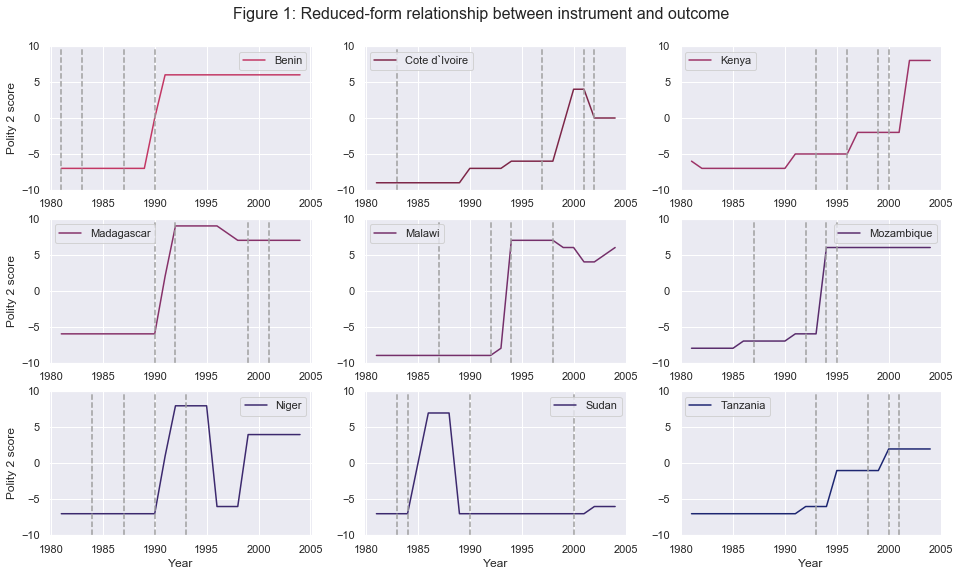

In [5]:
''' Countries presented in paper '''
country_codes = [434, 437, 501, 580, 553, 541, 436, 625, 510]

plot_reduced_form(country_codes, election=False)

In contrast to the reduced-form relationship of $Z$ and $Y$ depicted in *Figure 1*, the sequence of maps below illustrates the chain of mediation ($Z \rightarrow D \rightarrow Y$).

* Left map shows drought in snapshot year
* Center map depicts recession in snapshot year
* Right map reveals change in institutional score from snapshot to subsequent year

*Moving* from the left to the center map is essentially the first stage ($Z \rightarrow D$). A negative shock of the instrument leads to a recession in the same year due to a shortfall in agricultural produce. During these times of crop failure the opportunity cost to contest political power is lowered and the regime in power will deploy more demoratic institutions as a response to protest with a time lag of one year (center to right map), i.e. second stage, or $D \rightarrow Y$.

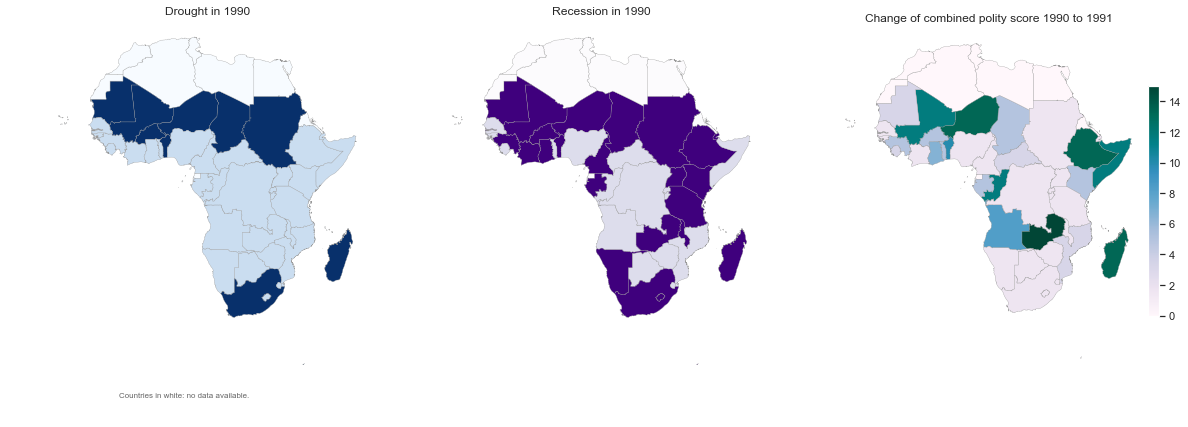

In [6]:
draw_story_map(1991)

Though the above maps are just a snapshot of the time investigated $-$ but a favorable, admittedly $-$ it may tell the reader the underlying story from a different perspective. Going from left to right, one sees that particularly countries with some territory in the Saharan desert suffered a drought in 1990 of which all faced a recession in the same year. The co-movement of recessions in 1990 and positive changes of the Polity score in 1991 is present for many countries. But there are a few prominent examples for which this is not the case $-$ i.e. an improvement in institutions occured without a prior recession or despite an economic downswing polity scores did not increase. With the exception of South Africa and Sudan, in countries whose recessions were triggered exogenously through a drought the polity score improved in the subsequent year.

Note that data in this visualization are very stylized, and are only to motivate the story. In the main analysis, instead of droughts and recessions, rainfall and GDP per capita are considered. Dummies have been chosen over continuous data for reasons of representation and intuition albeit a lot of information is discarded. Recessions are not instrumented. 

Also, for completeness see the maps below indicating that not every point in time is supportive of the story. The ``draw_story_map()`` method is built such that one can go through any year from 1981 to 2004.

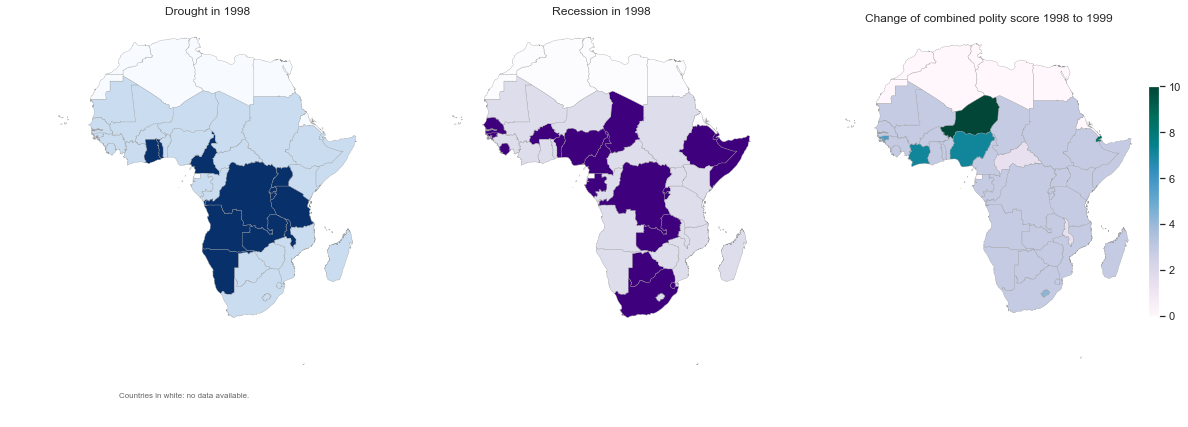

In [7]:
draw_story_map(1999)

### Estimation Framework

Two-stage Least Squares (2SLS) estimation is conducted to implement the IV design described. Both the first and second stage are estimated by OLS with country and time fixed effects. Additionally, all specifications include a country-specific time trend, and error terms are mean-zero. Coefficient's standard errors are clustered at the country level to account for potential serial correlation of the error term within countries across time. The data do not allow for clusters underneath the country dimension, and clusters with respect to geographical conditions are not considered. The error term is assumed to be independent across countries.

#### First Stage

To isolate the exogenous variation in GDP per capita, the treatment variable is regressed on the instrument which is assumed to not have any relationship with the outcome aside through income.

Including time and country fixed effects plus a country-specific time trend the first stage is depicted by 

\begin{align*}
log(GDP_{t, c}) = \alpha_{c}\ + \beta_{c}t\ + \phi_{t}\ + log(rainfall_{t, c}) + v_{t,c}
\end{align*}
<br>
where $v_{t,c}$ is the error term.

In [8]:
spec_1 = 'lgdp_l2 ~ lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'    
spec_2 = 'lgdp_l2 ~ lgpcp_l2 + lgpcp_l3 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_3 = 'lgdp_l2 ~ lgpcp_l2 + lgpcp_l3 + lgpcp_l4 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_4 = 'lgdp_l2 ~ lgpcp_l2 + lgpcp_l2_polity2l2 + polity2l2 + C(ccode) + C(ccode) : I(year) + C(year)'  
spec_5 = 'recession_l2 ~ lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_6 = 'recession_l2 ~ lgpcp_l2 + lgpcp_l3 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_7 = 'recession_l2 ~ lgpcp_l2 + lgpcp_l3 + lgpcp_l4 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_8 = 'recession_l2 ~ lgpcp_l2 + lgpcp_l2_polity2l2 + polity2l2 + C(ccode) + C(ccode) : I(year) + C(year)'

In [9]:
rslts = smf.ols(formula=spec_1, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['ccode']}).summary()
print(rslts)

C:\Users\Max\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 24
  'rank is %d' % (J, J_), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                lgdp_l2   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                -7.742e+11
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               1.00
Time:                        18:29:24   Log-Likelihood:                 881.63
No. Observations:                 955   AIC:                            -1553.
Df Residuals:                     850   BIC:                            -1043.
Df Model:                         104                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.07

**To do**: decide how regression output is presented.

Rainfall positively affects log GDP per capita contemporaneously and decreases the probability of a recession. Considering further robustness specifications (specification 2-4 and 6-8) including lagged rainfall, the combined polity score and an interaction between the combined polity score and rainfall does indicate that only rainfall in the same period significantly explains GDP per capita, and thus motivates the choice of the first-stage specification.

#### Second Stage

After *isolating* the clean variation in GDP per income $-$ fitted values of the first stage, indicated by a hat $-$ are included in the second stage regression. Further, time and country fixed effects plus a country-specific time trend are included. The resulting specification reads

\begin{align*}
log(\Delta\ polity2_{t, c}) = \alpha_{c}\ + \beta_{c}t\ + \phi_{t}\ + \widehat{log(GDP_{t-1, c})} + u_{t,c}
\end{align*}
<br>
where $u_{t,c}$ is the error term.

In [10]:
spec_first_stage = 'lgdp_l2 ~ lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'
rslt = smf.ols(formula=spec_first_stage, data=df).fit()
df['lgdp_l_hat'] = rslt.predict()

spec_second_stage = 'polity_change ~ lgdp_l_hat + C(ccode) + C(ccode) : I(year) + C(year)'
rslts = smf.ols(formula=spec_second_stage,data=df).fit(cov_type='cluster',cov_kwds={'groups':df['ccode']}).summary()
print(rslts)

C:\Users\Max\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 23
  'rank is %d' % (J, J_), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:          polity_change   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                -3.533e+11
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               1.00
Time:                        18:30:00   Log-Likelihood:                -1993.9
No. Observations:                 955   AIC:                             4198.
Df Residuals:                     850   BIC:                             4708.
Df Model:                         104                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.29

**To do**: present and comment on results

#### Context matters

Having had a glance at the first and second stage estimations, attention in this sub-section is focused on heterogeneous results given two sub-samples that are divided along their agricultural sector's size. For this purpose, Panel A refers to countries with an average agricultural GDP share in 1980-2004 below the sample median of 34.7%, and Panel B includes countries above.

As the left of the two subsequent maps shows, the agriculture's GDP share varies substantially across countries. This has consequences for the instrument's validity if sub-samples are considered. While rainfall still can be assumed exogenous, it may not be relevant for countries with a very small agricultural sector $-$ variation in rainfall will not cause much variation in GDP per capita. In other words, for small-agriculture-countries the instrument will unlikely shove them into treatment. 

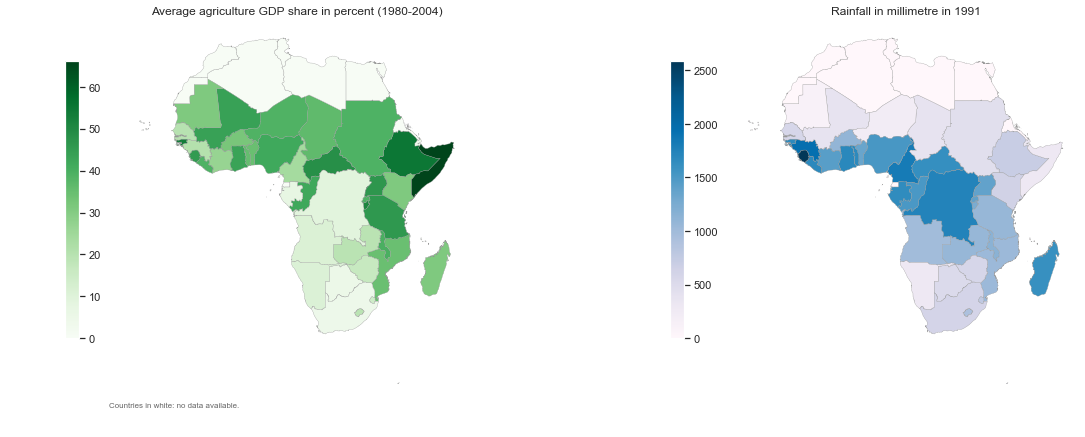

In [11]:
draw_settings_map(plot=1,year=1991)

An important condition:

> The agricultural sector substantially contributes to GDP and employs many individuals

An important condition for the instrument's relvance is that a substantial share of people work in the agricultural sector and are inevitably hit by produce failure due to droughts. This group may be best thought of as day laborers on larger farms, subsistency and small-holder farmers with little opportunity to smooth income flows (e.g. through storage, insurance or wealth liquidation). Since these individuals most likely have little wealth, less exposure to schooling and few outside options, they are vulnerable to income shocks (Fjelde and Uexkull (2012)). It renders also plausible that indivdiuals outside agriculture are adversely affected by income shocks induced by droughts. For instance, the (urban) poor see cuts in their disposable income if food prices increase. In that sense, not only individuals employed in agriculture may become protestors of more democratic institutions. 

However, as the following results show, the story does not hold for the sub-sample of countries with an agricultural GDP share below the median.

In [12]:
spec_1 = 'lgdp_l2 ~ lgpcp_l2 + lgpcp_l3 + C(ccode) + C(ccode) : I(year) + C(year)'
spec_2 = 'polity_change ~ lgpcp_l + lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'

In [13]:
agri_median = df['agri_gdp_av'].quantile(q=0.5)-0.0001
cluster_groups = df['ccode'][df['agri_gdp_av']>agri_median]

rslts = smf.ols(formula=spec_2,data=df[df['agri_gdp_av']>agri_median]).fit(cov_type='cluster',cov_kwds={'groups':cluster_groups}).summary()
print(rslts)

                            OLS Regression Results                            
Dep. Variable:          polity_change   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                -1.077e+12
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               1.00
Time:                        18:31:12   Log-Likelihood:                -1063.7
No. Observations:                 487   AIC:                             2259.
Df Residuals:                     421   BIC:                             2536.
Df Model:                          65                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.01

C:\Users\Max\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 66, but rank is 20
  'rank is %d' % (J, J_), ValueWarning)


The results reveal that rainfall does not have a significant effect on GDP in countries with an agricultural sector GDP share below the median (Panel A). Note that estimating the reduced-form by means of OLS does not yield a significant relationship between the instrument and the outcome. This is likely due to the weak correlation between the instrument rainfall and the treatment income. While this indicates that the chain of mediation ($Z \rightarrow D \rightarrow Y$) is not "effective", the insignificant relationship of the instrument and the outcome for the sub-sample with small agricultural GDP shares also does not offer a reason to reject the exclusive restriction assumption. Certainly, this is not proving that the exclusion restriction indeed holds true, in fact, this identifying assumption cannot be tested with the data (Morgan and Winship (2007)). However, there would be trouble in identifying the causal effect of interest if the instrument was to affect the outcome without correlating with the treatment.

For Panel B $-$ countries with agricultural GDP shares above the sample median $-$ the coefficient's magnitude and standard errors look differently. In fact, rainfall significantly affects income in the same period at the 5% confidence level, and estimates of the reduced-form relationship indicate that rainfall and the change in institutional scores have a negative relationship, i.e. a negative rainfall shock in year $t-1$ increases the combined polity score in $t$.

What do these different results for Panel A and Panel B countries mean for the instrument's relevance? While the instrument seems to be weak for countries with low agricultural GDP shares, the reverse holds for countries above the median. Recalling the full sample first-stage estimation reminds that rainfall is highly relevant in explaining GDP per capita movements. So, this *debate* shall not focus on the partial weak correlation between $Z$ and $D$ but rather the interpretability of the full sample 2SLS results is discussed in the next paragaph.

**The Local Average Treatment Effect** 

What came up in the previous discussion about the instrument causally affecting the treatment can be related to the concept of the *Local Average Treatment Effect* (LATE) developed by Imbens and Angrist (1994). The LATE offers a more precise concept to understand what $-$ or, in fact, *who* $-$ drives the 2SLS estimation results, and for whom the causal effect is informative.

As indicated by the preceding analysis the causal effect identified by this design is not informative for the entire set of countries, but rather for countries whose large agricultural sector left incomes vulnerable to rainfall shocks. These *compliers* are the set of countries that underwent treatment only due to the instrument's "push" into treatment, i.e. countries that witnessed an economic downturn in response to a negative rainfall shock. For the so-called *always-takers* who receive treatment in cases where the instrument does and does not "push" for treatment the LATE is uninformative. Therefore, the average treatment effect on the treated (ATT) is different to the LATE since for the former both compliers and always-takers are considered. One can show that the ATT is a weighted-average of treatment effects of both compliers and always-takers, see Angrist and Pischke (2009). 

To recover the LATE the monotonicity assumption is required in addition to the exogeneity, relevance and exclusive restriction assumptions described above. Monotonicity means in principle that the instrument's effect on the treatment variable must be either positive or negative for all units. In particular this does not allow the presence of *defiers* $-$ units that would receive treatment but do not if they are "pushed" intro treatment by the instrument. Here, this would be the case if countries were to fall into a recession but do not do so when a drought occurs. A plausible case for defiant behavior is given if a country is to avoid a recession when a drought occurs because as a response to the drought the government engages in expansionary fiscal policy to provide food and income to suffering farmers and the poor. Now consider the second group not receiving treatment: *never-takers* refer to objects not receiving treatment regardless of the instrument's value. Mapping this group to the underlying study, countries with a neglectable agricultural share can be considered never-takers as they do not respond to rainfall shocks with a recession $-$ by definition the LATE cannot be informative for this group.

**The Average Causal Response** $-$ *Generalizing the LATE*

Since for the main analysis GDP per capita as continuous variable is used as treatment the treatment intensity varies. That is, a similar-sized sudden and temporary decline in income does not have the same effect on institutional scores for different levels of initial income. The single coefficient reported in a linear causal model may lead the reader to believe that the treatment effect is constant for every initial level of income. However, Angrist and Imbens (1995) show that the 2SLS estimator is a weighted average of all unit causal responses, where the unit causal response is the average difference in potential outcomes of compliers at a given level of the treatment. In other words, the average effect on the outcome of countries moving from a certain intensity of treatment "to the next" due to the instrument's "push" is the unit causal response. Averaging over the range of treatment intensity while weighting by the share of compliers along it, gives the *Average Causal Response* (ACR). As noted by Angrist and Pischke (2009) the idea of the ACR extends to continuous treatment, as is the case here. The 2SLS estimator obtained from regressing the change in the combined polity score on instrumented income (and controlling for time and country fixed effects) is the ACR, driven by compliant countries that are subject to variable treatment intensity.

### Shedding Light on Mechanism

After discussing the interpretability of the recovered 2SLS estimator in the last section, attention is now turned to the mechanism that drives institutional development.

How do non-persistent negative income shocks result in improvements of democratic institutions? The authors argue that a temporary reduction in income decreases the opportunity cost to contest political power which opens a *window of opportunity* in which institutional scores improve. However, the precise mechanism how these changes come about is not thoroughly described. Shedding light on the mechanism addresses this short-coming, as the author's do not offer an explanation why the regime in power should respond to citizens' political preferences revealed in protests. This point may be even stronger for those regimes investigated which are autocratic given less political competition. Following Polity IV's definition of autocracies (a combined polity score of -10 to -6), the share of autocracies in the sample is 77.5% in 1981; see also the *settings map* below where the combined polity scores of sub-Saharan African countries at the beginning of the panel is presented.

While the authors rule out that democratic change is triggered by a coup d'état it remains unclear whether the political regime reacts to protests by passing laws, renewing the executive or other measures. A question arises: does the current executive change policy for the better after protests in the current institutional framework, or do elections need to fast-forward the way of institutional improvement?

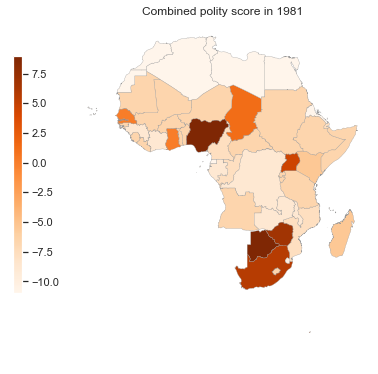

In [14]:
draw_settings_map(plot=2,year=1981)

In [17]:
polity2 = df.loc[df['year']==1981, 'polity2'].values
autoc_share = (polity2 < -5).sum()/(len(polity2))
print('\n\nThe share of autocratic regimes in the sample in 1981 equals {:}%.\n'.format(100*autoc_share))



The share of autocratic regimes in the sample in 1981 equals 77.5%.



#### The Role of Elections

General elections of the state's representatives and the executive are major political events that can change the political equilibrium of interests represented. The opposition generally has an interest to convince voters to bring a breath of fresh air into politics and address people's preferences. In response to a shift in preferences not addressed by the policy of the regime in power, the latter may be incentiviced to adopt policies of newly formulated demands so to not lose legitamicy or the people's goodwill. To pin down this idea, consider this placative example: think of sub-Saharan farmers to protest for more constraints on the executive as they fear that their agricultural land will be sold to the regime's good friends. They would not have protested if it was not during a drought since their costs to protest are low when income opportunites on the field are low. As the agricultural sector's GDP share is large, many work in agriculture and feel the same way. The opposition has an incentive to win over the farmers as voters and pledge to change the constitution in favor of a more balanced executive. On the other hand, the regime in power may fear to be voted of out office $-$ or in a more autocratic setting: to face riots and disobedience $-$ and promises to constrain the chief executive. While the government's worry may exist for all protests, it seems reasonable to believe that the actual risk to lose power is larger during times of elections. Also, the opposition $-$ if there is any $-$ may gain more ground for their matters in times of election.

> A critical note on elections: 
* Elections are not randomly drawn from a distribution but follow a pre-determined rule or are re-scheduled due to government failure. Moreover, large protests may cause premature elections if protestors attest a complete failure of the executive. Perhaps, the decision to protest in fact depends on whether there is an election or not, as the expected impact of protesting is larger shortly before an election when the threat to deselection is still credible. If one considers protests to be the country's treatment in times of reduced opportunity cost, then there may be selection into treatment based on an election held in that year. While this is not a threat to the validity of the 2SLS estimator, it offers more insight into the mechanism of how institutional change is triggered.
* An assumption made: it is ruled out that having an election is already an improvement in itself. That is, if a country never had elections, and suddenly introduces them, the combined polity score in the year of the first vote will improve due to the introduction of elections. Then, the improvement in polity scores cannot come through the election channel, and protests will directly improve polity scores in the first year of votings $-$ having a primal election is part of the outcome. However, since most countries have had votes (with varying degree of freedom and political competition) over the time investigated no attention beyond this note is provided.


In [16]:
print("\n\nIn the sample {:} elections were held.\n".format(len(df[df['election']==1])))



In the sample 142 elections were held.



**Elections** $-$ yet another mechanism

How do people in sub-Saharan Africa react to non-persistent negative income shocks? The author's idea is that individuals hit by a negative shock to income see their opportunity cost to protest decrease and contest power by protesting. During elections contesting power may be even more worth undertaking assuming that protests have a larger effect shortly before voting. However, a low-cost alternative or complement to protesting in times of election is simply to vote. 

The importance of elections as a signal of dissatisfaction with the regime in power can be strong. While for democracies this seems intuitive, the case for autocracies may not be as alternative political choices are at least limited. Nevertheless, there is some evidence that autocratic elections have an effect on policy-making, e.g. Miller (2015) finds that "falling vote totals for the ruling party predict policy concessions following the elections" for a sample of 86 autocratic countries from 1975 to 2004. However, policies rather lead to less military and more social welfare spending, which are not linked to the polity scores.

Due to the nature of political decision-making and the annual data one cannot precisely pin-down the timing of democratization. It is therefore not possible in this setting to attribute the observed changes in institutional scores to the effect of protests before elections or political responses in the aftermath of them. The underlying paper supports the former while Miller (2015) argues in favor of the latter.

Leaving these details behind, the following section will embed elections as a mechanism through which the treatment affects the outcome, and yields a strong case favoring the pivotal role of elections.

**Causal Graph** $-$ The case with elections

Updating the research design requires a revised causal graph. The chain of mediation is extended to exhibit another node $E$ representing an election dummy and is given by ($Z \rightarrow D \rightarrow E \rightarrow Y$). During treatment opportunity cost of contesting power declines but the resulting protests are only able to cause institutional improvements when there is an election in the same year, see *Graph 5*:


*Graph 5*
<img src="graphs/causal_graph_5.png" height=500 width=500 />

<br>

**Estimation Framework** $-$ The case with elections

Following the specification as described above, the first stage estimation is unaffected, and given by

\begin{align*}
log(GDP_{t, c}) = \alpha_{c}\ + \beta_{c}t\ + \phi_{t}\ + log(rainfall_{t, c}) + v_{t,c}
\end{align*}
<br>
where $v_{t,c}$ is the error term.

The second stage's specification is similar to the earlier case, but the instrumented treatment is now interacted with an election dummy $I(election_{t,c})$. It is equal to 1 if elections were held in the respective year and country, and zero otherwise. Further, the election dummy enters the specification by itself.

\begin{align*}
log(\Delta\ polity2_{t, c}) = \alpha_{c}\ + \beta_{c}t\ + \phi_{t}\ + \widehat{log(GDP_{t-1, c})}*I(election_{t,c}) + I(election_{t,c}) + e_{t,c}
\end{align*}
<br>
where $e_{t,c}$ is the error term.

In [18]:
spec_first_stage = 'lgdp_l2 ~ lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'
rslt = smf.ols(formula=spec_first_stage, data=df).fit()
df['lgdp_l_hat'] = rslt.predict()

df['lgdp_l_hat_elect'] = df['lgdp_l_hat'] * df['election']

spec_second_stage = 'polity_change ~ lgdp_l_hat + lgdp_l_hat_elect + election + C(ccode) + C(ccode) : I(year) + C(year)'
spec_second_stage = 'polity_change ~ lgdp_l_hat_elect + election + C(ccode) + C(ccode) : I(year) + C(year)'
rslts = smf.ols(formula=spec_second_stage,data=df).fit(cov_type='cluster',cov_kwds={'groups':df['ccode']}).summary()
print(rslts)

C:\Users\Max\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 106, but rank is 25
  'rank is %d' % (J, J_), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:          polity_change   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                -1.873e+12
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               1.00
Time:                        18:41:41   Log-Likelihood:                -1968.6
No. Observations:                 955   AIC:                             4149.
Df Residuals:                     849   BIC:                             4665.
Df Model:                         105                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.11

**To do**: check effect on government expenditures

In [ ]:
spec_first_stage = 'lgdp_l2 ~ lgpcp_l2 + C(ccode) + C(ccode) : I(year) + C(year)'
rslt = smf.ols(formula=spec_first_stage, data=df).fit()
df['lgdp_l_hat'] = rslt.predict()

df['lgov_change'] = df['lgov'] - df['lgov_l']
df_temp = df.dropna(subset=['lgov_change'])

spec_second_stage = 'lgov_change ~ lgdp_l_hat + C(ccode) + C(ccode) : I(year) + C(year)'

rslts = rslt = smf.ols(formula=spec_second_stage, data=df_temp).fit(cov_type='cluster', cov_kwds={'groups':df_temp['ccode']}).summary()
print(rslts)

Note that the research design is not able to provide sophisticated answers for causally explaining government or military expenditure. The results presented should be regarded with even greater carefulness. Attesting some usefulness to the results, they do not give a reason to believe that countries with temporarily reduced GDP per income (induced by the exogenous variation in rainfall) respond with increased military or government expenditure. The ACR for government expenditure is negative $-$ indicating that in times of economic stress fiscal policy is rather lose $-$ but not significant at any reasonable significance level.

### Concluding Remarks


#### References

IDEA (International Institute for Democracy and Electoral Assistance), [link to data](https://www.idea.int/data-tools/continent-view/Africa/40), accessed: 02-June-2019

Fjelde, H., von Uexkull, N. (2012). Climate triggers: rainfall anomalies, vulnerability and communal conflict in sub-Saharan Africa. Political Geography, 31(7), pp. 444-453.

Imbens, G. and Angrist, J. (1994). Identification and Estimation of Local Average Treatment Effects. Econometrica, 62(2), pp. 467-475. 

Morgan, S. L. and Winship, C. (2007). Counterfactuals and Causal Inference: Methods and Principles for Social Research. Cambridge: Cambridge University Press (Analytical Methods for Social Research).

Rosenzweig, M. and Wolpin, K. (2000). Natural "Natural Experiments" in Economics. Journal of Economic Literature, 38(4), pp. 827-874.